# Обработка естественного языка

## Задача

Преобразовать текстовую информацию в цифровую, для дальнейшей обработки.  
Методы обработки: 
* Bag of Words
* TF-IDF 
* Word2Vec
* FastText
* Doc2Vec

## Данные

Более 48 тысяч отзывов, записанные в *data/reviews_2020_2023.csv*

## Расчёты

In [1]:
from nltk.corpus import stopwords
import pymorphy2
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from gensim.models import TfidfModel, Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
import matplotlib.pyplot as plt

In [2]:
# стопслова
stopwords = list(stopwords.words('russian'))

# объект для получения лемм (лкмма - начальная, словарная форма слова)
morph = pymorphy2.MorphAnalyzer(lang='ru')

# функция лемматизации слов и удаления стопслов
def get_lemma_without_stopwords(row):
    row = re.findall('[a-zа-яё]+', ' '.join(row).lower())
    output = []
    for word in row:
        lemma = morph.parse(word)[0].normal_form
        if lemma not in stopwords:
            output.append(lemma)
    return output


# функция для подсчёта слов в текстах
def word_count(column, unique=False):
    if unique:
        unique_words = set()
        for row in column:   
            unique_words |= set(row)
        count = len(unique_words)
    else:
        count = column.apply(lambda x: len(x)).sum()
    return count

In [3]:
# запись всех текстов в DataFrame
df = pd.read_csv('data/reviews_2020_2023.csv', sep='|', encoding='utf-8')
df

,type,review
0,bad,Действие фильма происходят в 1944 году на терр...
1,good,Очередная обошедшая зрителя картина. Люблю так...
2,bad,Нереально растянутая анимация ни о чем..Вот се...
3,good,"Про то, какая жизнь приятная и красочная, когд..."
4,good,В переводе с английского “Entergalactic” значи...
...,...,...
48785,neutral,Не имею ни малейшего представления о том как я...
48786,neutral,Что-то среднее между арт-хоррором и трешем. Не...
48787,good,Четверо друзей – бородатый оператор Робби с бр...
48788,neutral,Инди-хоррор в жанре «найденной плёнки» о столк...


In [4]:
# подсчёт процентного соотношения отзывов каждого типа
temp = df['type'].value_counts() / df.shape[0] * 100
for i, j in zip(temp.index, temp.values):
    print(f"{i}\t {j:.2f} %")

good	 60.08 %
bad	 20.69 %
neutral	 19.22 %


In [5]:
# Каждый текст представляем в виде списка слов
df['review'] = df['review'].apply(lambda x: x.split(' '))
df

,type,review
0,bad,"[Действие, фильма, происходят, в, 1944, году, ..."
1,good,"[Очередная, обошедшая, зрителя, картина., Любл..."
2,bad,"[Нереально, растянутая, анимация, ни, о, чем....."
3,good,"[Про, то,, какая, жизнь, приятная, и, красочна..."
4,good,"[В, переводе, с, английского, “Entergalactic”,..."
...,...,...
48785,neutral,"[Не, имею, ни, малейшего, представления, о, то..."
48786,neutral,"[Что-то, среднее, между, арт-хоррором, и, треш..."
48787,good,"[Четверо, друзей, –, бородатый, оператор, Робб..."
48788,neutral,"[Инди-хоррор, в, жанре, «найденной, плёнки», о..."


In [6]:
# подсчёт количества слов до лемматизации
print(f"Слов до предобработки: {word_count(column=df['review'], unique=False)}")
print(f"Уникальных слов до предобработки: {word_count(column=df['review'], unique=True)}")

Слов до предобработки: 18834935
Уникальных слов до предобработки: 1050026


In [7]:
# лемматизация текстов
tqdm.pandas()

df.review = df['review'].progress_apply(get_lemma_without_stopwords)
df

  0%|          | 0/48790 [00:00<?, ?it/s]

,type,review
0,bad,"[действие, фильм, происходить, год, территория..."
1,good,"[очередной, обойти, зритель, картина, любить, ..."
2,bad,"[нереально, растянутый, анимация, серьёзно, пр..."
3,good,"[жизнь, приятный, красочный, творческий, лёгки..."
4,good,"[перевод, английский, entergalactic, значит, в..."
...,...,...
48785,neutral,"[иметь, малый, представление, узнать, это, фил..."
48786,neutral,"[средний, арт, хоррор, трехать, неудобный, мок..."
48787,good,"[четверо, друг, бородатый, оператор, робби, бр..."
48788,neutral,"[инди, хоррор, жанр, найти, плёнка, столкновен..."


In [8]:
# подсчёт количества слов после лемматизации
print(f"Слов после предобработки: {word_count(column=df['review'], unique=False)}")
print(f"Уникальных слов после предобработки: {word_count(column=df['review'], unique=True)}")

Слов после предобработки: 12123985
Уникальных слов после предобработки: 142511


In [9]:
# составление выборки для обучения и для теста
df_train, df_test = train_test_split(df, train_size=0.9, shuffle=True)

print(f"Размер тестовой выборки:\t{len(df_train)}")
print(f"Размер валидационной выборки:\t{len(df_test)}")

Размер тестовой выборки:	43911
Размер валидационной выборки:	4879


In [10]:
# сохранение лемматизированных текстов
df_train.to_pickle('data/train/df.pkl')
df_test.to_pickle('data/test/df.pkl')

99% текстов состоит из 451 слов или меньше


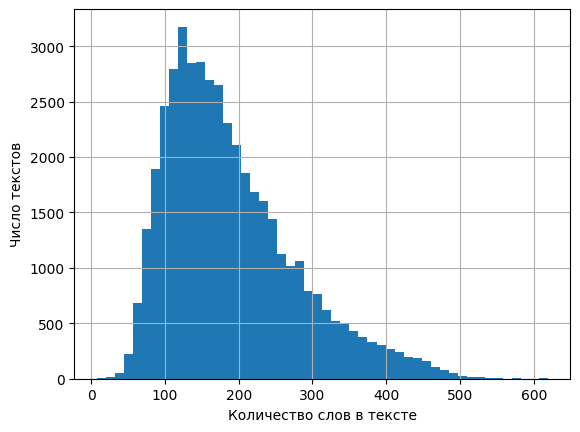

In [11]:
# количесвто слов в текстах из обучающей выборки
number_of_words = int(df_train.review.apply(lambda x: len(set(x))).quantile(0.99))
print(f"99% текстов состоит из {number_of_words} слов или меньше")

df_train.review.apply(lambda x: len(set(x))).hist(bins=50)
plt.xlabel("Количество слов в тексте")
plt.ylabel("Число текстов")
plt.show()

In [12]:
# составление словаря для дальнейшей обработки
dictionary = Dictionary(df_train['review'])

# фильтрация слов по частоте
# слово должно быть как минимум в трёх текстах
# максимально возможная величина словаря = числу всех уникальных слов
dictionary.filter_extremes(
    no_below=3,
    keep_n=word_count(column=df_train['review'], unique=True)
)

In [13]:
# составляем Bag of Words для обучающей выборки
bow_train = corpus2csc(
    [dictionary.doc2bow(doc) for doc in df_train['review']], 
    num_terms=len(dictionary)
).T

# составляем Bag of Words для тестовой выборки
bow_test = corpus2csc(
    [dictionary.doc2bow(doc) for doc in df_test['review']], 
    num_terms=len(dictionary)
).T

bow_train.shape, bow_test.shape

((43911, 60784), (4879, 60784))

In [14]:
# сохранение
dictionary.save('data/dictionary')
sparse.save_npz('data/train/bow.npz', matrix=bow_train)
sparse.save_npz('data/test/bow.npz', matrix=bow_test)

In [15]:
# составление TF-IDF для обучающей выборки
tf_idf = TfidfModel(
    corpus=[dictionary.doc2bow(document=doc) for doc in df_train['review']]
)

# составление TF-IDF для тестовой выборки
tf_idf_train = corpus2csc(
    tf_idf[[dictionary.doc2bow(doc) for doc in df_train['review']]], 
    num_terms=len(dictionary)
).T

tf_idf_test = corpus2csc(
    tf_idf[[dictionary.doc2bow(doc) for doc in df_test['review']]], 
    num_terms=len(dictionary)
).T

tf_idf_train.shape, tf_idf_test.shape

((43911, 60784), (4879, 60784))

In [16]:
# сохранение
sparse.save_npz('data/train/tf_idf.npz', matrix=tf_idf_train)
sparse.save_npz('data/test/tf_idf.npz', matrix=tf_idf_test)

In [17]:
# устанавливаем размер векторов для Word2Vec, FastText, Doc2Vec
VECTOR_SIZE = 100

In [18]:
# обучение Word2Vec модели
w2v = Word2Vec(
    sentences=df_train['review'], 
    vector_size=VECTOR_SIZE, 
    window=5, 
    min_count=3, 
    epochs=10, 
    sg=1, 
    workers=os.cpu_count()
)

In [19]:
# преобразование обучающих текстов в векторы
w2v_train = np.stack(
    df_train['review'].progress_apply(lambda x: w2v.wv.get_mean_vector(keys=x, pre_normalize=False))
)

# преобразование тестовых текстов в векторы
w2v_test = np.stack(
    df_test['review'].progress_apply(lambda x: w2v.wv.get_mean_vector(keys=x, pre_normalize=False))
)

w2v_train.shape, w2v_test.shape

  0%|          | 0/43911 [00:00<?, ?it/s]

  0%|          | 0/4879 [00:00<?, ?it/s]

((43911, 100), (4879, 100))

In [20]:
# сохранение
w2v.save('data/word2vec.model')
np.save('data/train/w2v.npy', arr=w2v_train)
np.save('data/test/w2v.npy', arr=w2v_test)

In [21]:
# обучение FastText модели
fasttext = FastText(
    sentences=df_train['review'], 
    vector_size=VECTOR_SIZE, 
    window=5, 
    min_count=3, 
    epochs=10, 
    sg=1, 
    workers=os.cpu_count(), 
    min_n=2, 
    max_n=6
)

In [22]:
# преобразование обучающих текстов в векторы
fasttext_train = np.stack(
    df_train['review'].progress_apply(lambda x: fasttext.wv.get_mean_vector(keys=x, pre_normalize=False))
)

# преобразование тестовых текстов в векторы
fasttext_test = np.stack(
    df_test['review'].progress_apply(lambda x: fasttext.wv.get_mean_vector(keys=x, pre_normalize=False))
)

fasttext_train.shape, fasttext_test.shape

  0%|          | 0/43911 [00:00<?, ?it/s]

  0%|          | 0/4879 [00:00<?, ?it/s]

((43911, 100), (4879, 100))

In [23]:
# сохранение
fasttext.save('data/fasttext.model')
np.save('data/train/fasttext.npy', arr=fasttext_train)
np.save('data/test/fasttext.npy', arr=fasttext_test)

In [24]:
# маркеруем каждый текст обучающей выборки уникальным номером
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_train['review'])]

# обучение Doc2Vec модели
d2v = Doc2Vec(
    documents=documents, 
    vector_size=VECTOR_SIZE, 
    window=5, 
    min_count=3, 
    epochs=10, 
    workers=os.cpu_count()
)

In [25]:
# преобразование обучающих текстов в векторы
d2v_train = np.stack([d2v.dv[i] for i in range(len(df_train))])

# преобразование тестовых текстов в векторы
d2v_test = np.stack(df_test['review'].progress_apply(lambda x: d2v.infer_vector(x, epochs=50)))

d2v_train.shape, d2v_test.shape

  0%|          | 0/4879 [00:00<?, ?it/s]

((43911, 100), (4879, 100))

In [26]:
# сохранение
d2v.save('data/doc2vec.model')
np.save('data/train/d2v.npy', arr=d2v_train)
np.save('data/test/d2v.npy', arr=d2v_test)

## Результаты

Была проведена лемматизация текстов, обучение Word2Vec и FastText моделей.  
Каждый текст был представлен в виде вектора пятью разными способами (BOW, TF-IDF, Word2Vec, FastText, Doc2Vec)